# Comparison of Full Grid Stereo with Window-based and Scanline Approaches

## Team members and contributions

- Soyeon Shin:

- Umer Amjad:

## Code Libraries
(acknowledge all external code libraries "essential" for your project. You should explain the importance of each such library for your project. If these libraries are not installed with the default anaconda package, provide installation instructions/links or include the necessary files in extlibs subdirectory.)

pip install opencv-python

## Abstract
TODO: two-three paragraph abstract outlining the high-level goal and discussing well-motivated methodology of the project

First, we have pasted the solutions for window based stereo and scanline stereo from A3 to compare
....

then we do graph cuts stereo 
...

extensions

## Load Images
TODO: Here we load up the images, resizing (we scale the images down because otherwise they are too large), calculating the minimum and maximum disparities, and store the results in a dictionary for use in our algorithms

In [1]:
%matplotlib inline
import re
import cv2
import os
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.colors import LogNorm
from PIL import Image
from skimage import img_as_ubyte
from skimage.color import rgb2grey

# read image with pillow and convert to np array
def im_read(image_path):
    return np.array(Image.open(image_path))

# source: https://gist.github.com/chpatrick/8935738
# this function is used to load PFM files containing ground truth for Middlebury dataset
def load_pfm(file):
    file = open(file, 'rb')

    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().rstrip()
    if header.decode('ascii') == 'PF':
        color = True    
    elif header.decode('ascii') == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.search(r'(\d+)\s(\d+)', file.readline().decode('ascii'))
    if dim_match:
        width, height = map(int, dim_match.groups())
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().rstrip())
    if scale < 0: # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>' # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)
    return np.reshape(data, shape), scale

# first add Tsukuba images

image_dir = "images/"
tsukuba_dir = image_dir + "tsukuba/"

# dict of image to image info
images = {}

# images/tsukuba subdirectory contains (a subset of) "Tsukuba" stereo images that are probably 
# the oldest stereo data with dense ground-truth produced at the University of Tsukuba in 2001. 
# The full Tsukuba dataset and many other stereo images with ground-truth disparity maps can be
# downloaded from well-known Middlebury repository  http://vision.middlebury.edu/stereo/
im_left = im_read(tsukuba_dir + "scene1.row3.col3.ppm")
im_right = im_read(tsukuba_dir + "scene1.row3.col4.ppm")
im_gt = im_read(tsukuba_dir + "truedisp.row3.col3.pgm")
# disparities scaled by 16
im_gt = im_gt / 16

d_min = int(np.amin(im_gt[np.nonzero(im_gt)]))
d_max = int(np.amax(im_gt))

images['tsukuba'] = {
    'left': im_left,
    'right': im_right,
    'gt': im_gt,
    'd_min': d_min,
    'd_max': d_max
}

middlebury_dir = image_dir + "Middlebury/"

for d in os.listdir(middlebury_dir):
    im_left = im_read(middlebury_dir + d + "/im0.png")
    im_right = im_read(middlebury_dir + d + "/im1.png")
    
    scale_down = 4
    # scale the images 
    scaled_dim = (int(im_left.shape[1] / scale_down), int(im_left.shape[0] / scale_down))
    im_left = cv2.resize(im_left, scaled_dim, interpolation = cv2.INTER_AREA)
    im_right = cv2.resize(im_right, scaled_dim, interpolation = cv2.INTER_AREA)

    im_gt, _ = load_pfm(middlebury_dir  + d + "/disp0.pfm")
    im_gt = np.flip(im_gt, axis = 0) # load pfm gives it upside down
    im_gt = cv2.resize(im_gt, scaled_dim, interpolation = cv2.INTER_AREA)
    im_gt = im_gt/scale_down
    
    d_min =  int(np.amin(im_gt[im_gt != np.inf]))
    d_max = int(np.amax(im_gt[im_gt != np.inf]))

    im_gt[im_gt==np.inf] = 0
    
    # store in dictionary for later use
    images[d] = {
        'left': im_left,
        'right': im_right,
        'gt': im_gt,
        'd_min': d_min,
        'd_max': d_max
    }
    


## Display Images
Below we display the left and right images, along with ground truth disparities. We also define functions to help display which we use later too. 

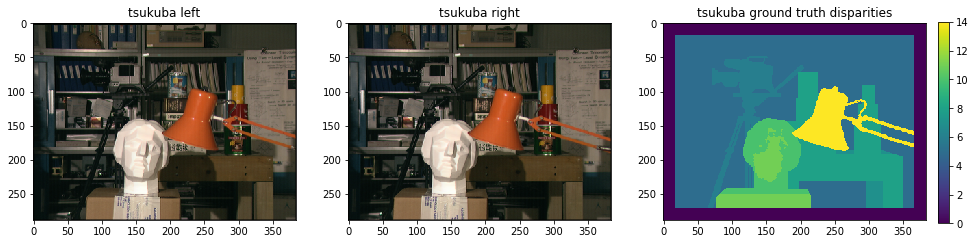

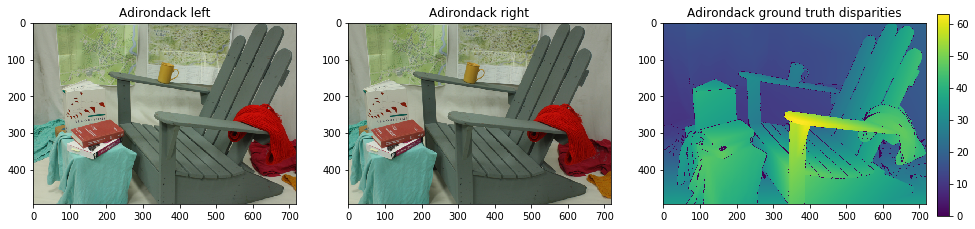

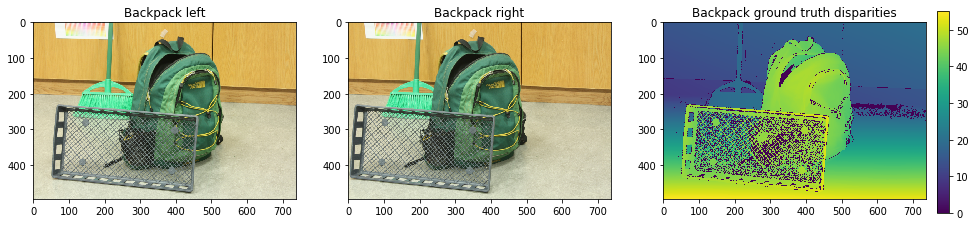

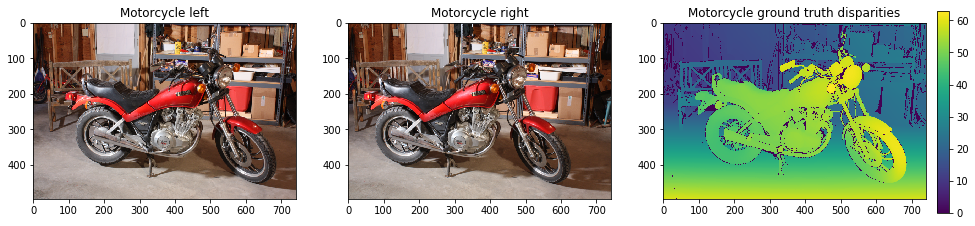

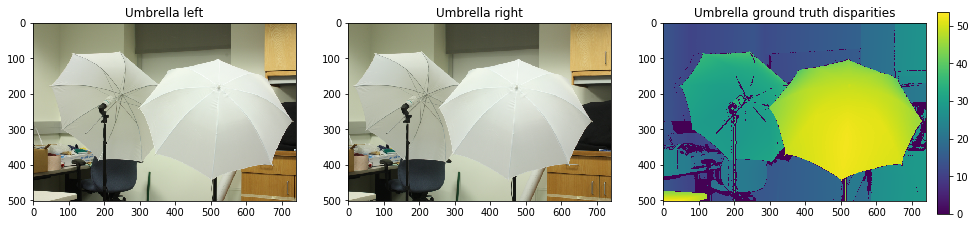

In [2]:
# plots a row of images
# if using vmin and vmax, they must share that value 
def display_image_plots(plots, titles, fig_size = (16, 7), vmin = None, vmax = None, colorbar_info = None):
    fig = plt.figure(figsize = fig_size)
    plot_location = 100 + len(plots)*10
    for i, plot in enumerate(plots):
        plt.subplot(plot_location + i + 1)
        plt.title(titles[i])
        if vmin and vmax:
            plt.imshow(plot, vmin = vmin, vmax = vmax)
        else:
            plt.imshow(plot)
    if colorbar_info:
        plt.colorbar(cax = plt.axes(colorbar_info))
    plt.show()
        

# display left, right, and gt

for name, info in images.items():
    plots = [info['left'], info['right'], info['gt']]
    titles = [name + " left", name + " right", name + " ground truth disparities"]
    display_image_plots(plots, titles, colorbar_info = [0.91, 0.3, 0.01, 0.4])

    

## Window-based Stereo

Description TODO

In [3]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.colors import LogNorm
from skimage import img_as_ubyte
from skimage.color import rgb2grey

INFTY = np.inf
def SD_array(imageL, imageR, d_minimum, d_maximum):
    # initialization of the array of "squared differences" for different shifts
    SD = np.zeros((1+d_maximum-d_minimum,np.shape(imageL)[0],np.shape(imageL)[1]))
    imlf = imageL
    imrf = imageR
    
    for i, d in enumerate(range(d_minimum, d_maximum+1)):
        shiftr = np.roll(imrf, d, axis = 1)
        SD[i] = np.sum(np.square(imlf - shiftr), axis = 2)

    return SD

def integral_image(img):
    integral = np.zeros((np.shape(img)[0],np.shape(img)[1]))
    for r, row in enumerate(img):
        row_sums = np.cumsum(row)
        integral[r] = row_sums
        if r > 0:
            integral[r] += integral[r-1]
    return integral

def windSum(img, window_width):
    integral = integral_image(img)
    forward_half = window_width // 2
    backward_half = window_width - forward_half

    br = np.roll(integral, (-forward_half, -forward_half), axis = (0, 1)) # bottom right
    bl = np.roll(integral, (-forward_half, backward_half), axis = (0, 1)) # bottom left
    tr = np.roll(integral, (backward_half, -forward_half), axis = (0, 1)) # top right
    tl = np.roll(integral, (backward_half, backward_half), axis = (0, 1)) # top left
    
    result =  br - bl - tr + tl
    if window_width > 1:
        if backward_half > 0:
            result[:backward_half, :] = INFTY
            result[:, :backward_half] = INFTY
        if forward_half > 0:
            result[-forward_half:, :] = INFTY
            result[:, -forward_half:] = INFTY
    return result

def SSDtoDmap(SSD_array, d_minimum, d_maximum):
    argmin = np.argmin(SSD_array, axis=0)
    minval = np.take_along_axis(SSD_array, np.expand_dims(argmin, axis = 0), axis = 0)[0, : , :]
    dmap = d_minimum + argmin
    return np.where(np.isinf(minval), 0, dmap)

def Dmap_Windows(imageL, imageR, d_minimum, d_maximum, window_width):
    SD = SD_array(imageL, imageR, d_minimum, d_maximum)
    SSD = np.zeros(np.shape(SD))
    for d in range(1 + d_maximum - d_minimum):
        SSD[d] = windSum(SD[d], window_width)
    dMap = SSDtoDmap(SSD, d_minimum, d_maximum)
    return dMap 

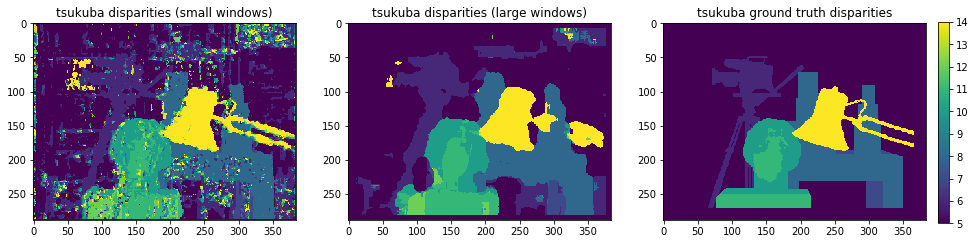

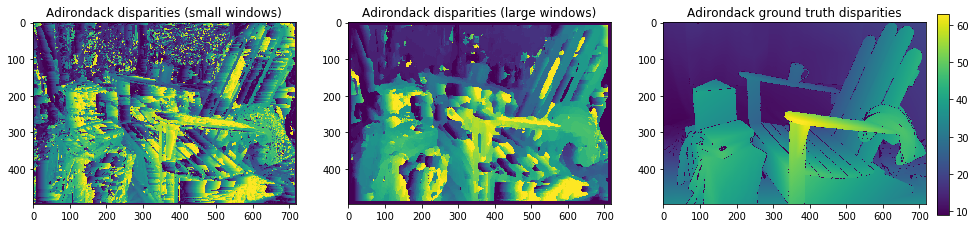

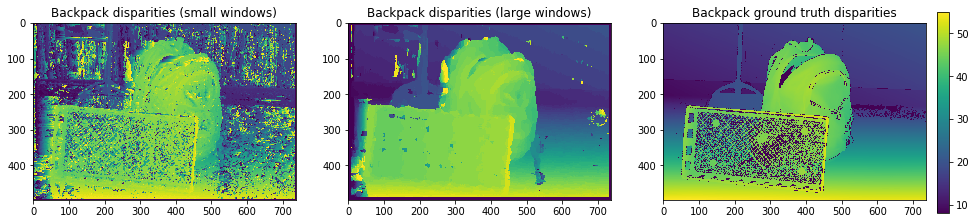

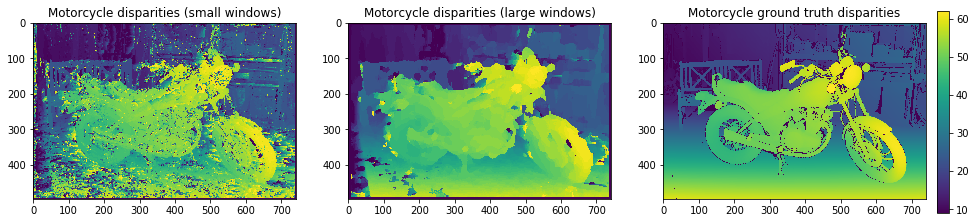

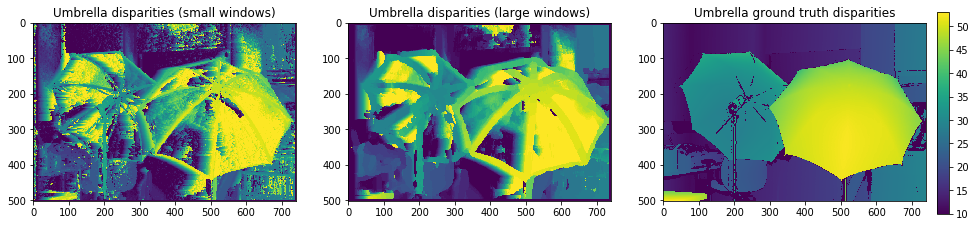

In [4]:
for name, info in images.items():
    images[name]['window_small'] = Dmap_Windows(info['left'], info['right'], info['d_min'], info['d_max'], 4)
    images[name]['window_large'] = Dmap_Windows(info['left'], info['right'], info['d_min'], info['d_max'], 15)
    plots = [images[name]['window_small'], images[name]['window_large'], info['gt']]
    titles = [name + " disparities (small windows)", name + " disparities (large windows)", name + " ground truth disparities"]
    display_image_plots(plots, titles, vmin = info['d_min'], vmax = info['d_max'], colorbar_info = [0.91, 0.3, 0.01, 0.4])


## Scan-line Stereo

Basic scanline, where the photo-consistency term of the loss function (objective function) is implemented $\text{SD_array}$ 

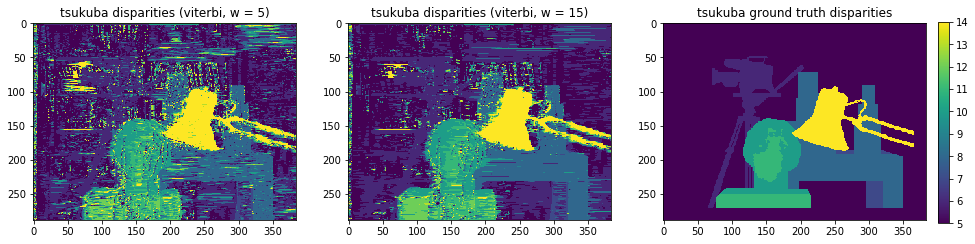

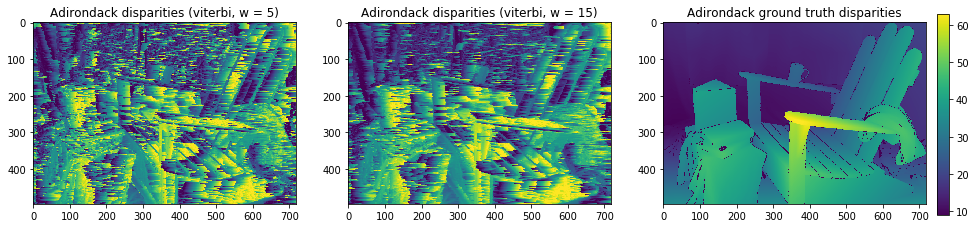

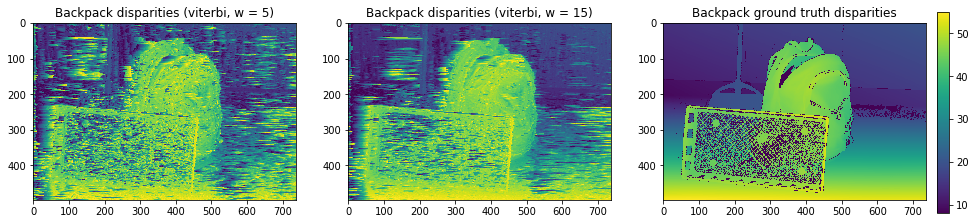

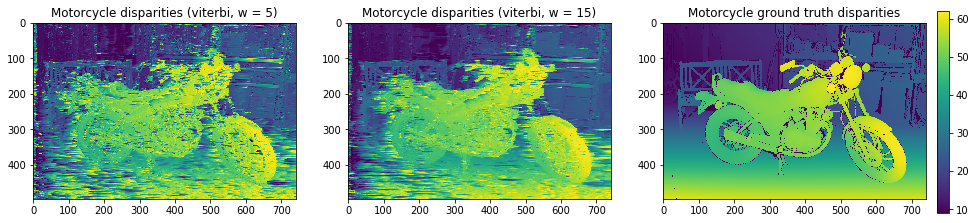

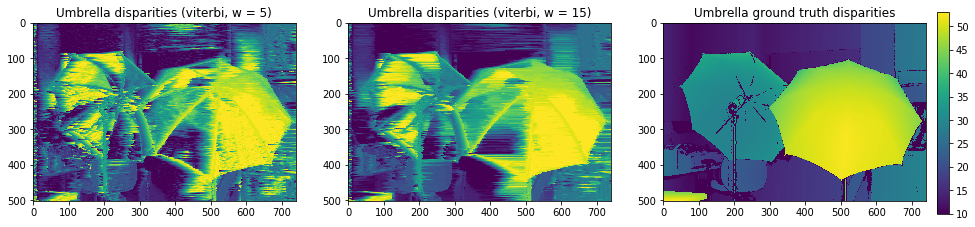

In [5]:

# returns E, Prev
def Viterbi(r, scanline, disps, photo_const, reg_weight):
    E = np.zeros((len(scanline), len(disps))) # row i is E_bar_i()
    Prev = np.zeros((len(scanline), len(disps)), dtype = int) # keep track of minimum chosen 
    for c, cell in enumerate(scanline):
        if c == 0:
            continue
        prev_E = np.tile(E[c-1], (len(disps), 1))
        photo_consts = np.tile(photo_const[:, r , c-1], (len(disps), 1))
        loss = reg_weight + prev_E + photo_consts
        Prev[c] = np.argmin(loss, axis = 1)
        E[c] = loss[np.arange(np.shape(loss)[0]), Prev[c]]
    return E, Prev


def dispMapViterbi(img, disps, photo_const, reg_weight):
    dispMap_viterbi = np.zeros((np.shape(img)[0], np.shape(img)[1]))
    for r, scanline in enumerate(img):
    
        E, Prev = Viterbi(r, scanline, disps, photo_const, reg_weight)
        # look at index of min of last row of E
        index =  np.argmin(E[-1])
        # get back all previous disparaties based on that minimum
        for c in reversed(range(len(scanline))):
            dispMap_viterbi[r][c] = disps[index]
            index = Prev[c][index]
    return dispMap_viterbi

# w is the regulization factor
def basic_viterbi_dispmap(im_left, im_right, d_min, d_max, w):
    # SD gives the array of Dp(d) for pixel p and disparity d
    # So to get edge costs E(p, p+1) = Dp + V(p, p+1)
    # we can create an array of edge costs:
    SD = SD_array(im_left, im_right, d_min, d_max)
    
    disps = np.array(range(d_min, d_max + 1))
    # matrix of regularization weights for disparities:
    disp_curr = np.transpose(np.tile(disps, (len(disps), 1)))
    disp_prev = np.tile(disps, (len(disps), 1))
    reg_weight = w * np.absolute(disp_curr - disp_prev)
    
    return dispMapViterbi(im_right, disps, SD, reg_weight)

for name, info in images.items():
    images[name]['viterbi_low_w'] = basic_viterbi_dispmap(info['left'], info['right'], info['d_min'], info['d_max'], 5)
    images[name]['viterbi_high_w'] = basic_viterbi_dispmap(info['left'], info['right'], info['d_min'], info['d_max'], 15)
    plots = [images[name]['viterbi_low_w'], images[name]['viterbi_high_w'], info['gt']]
    titles = [name + " disparities (viterbi, w = 5)", name + " disparities (viterbi, w = 15)", name + " ground truth disparities"]
    display_image_plots(plots, titles, vmin = info['d_min'], vmax = info['d_max'], colorbar_info = [0.91, 0.3, 0.01, 0.4])

Test the case where the photoconsistency term $D_p(d)$ is computed by averaging SD in some small window of size $h$. That is, for each disparity $d$ you should replace 2D array $\text{SD_array}(d)$ in Problem 7(a) by $$\text{SD_array}(d)   \;\;\;\;\;\longleftarrow\;\;\;\;  windSum(SD(d),h).$$ Compare the results for different window sizes $h\in\{1,3,5\}$. Feel free to fine tune regularization parameter $w$ for each case trying to obtain the better results. 

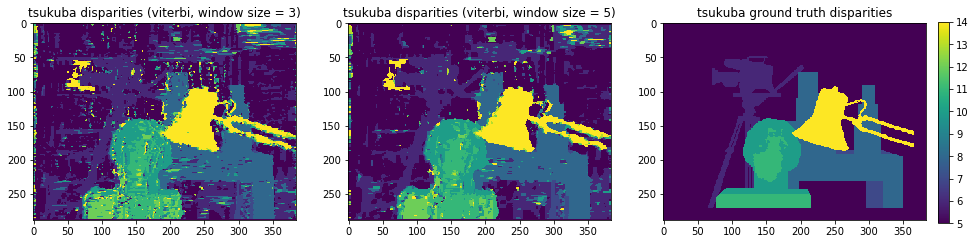

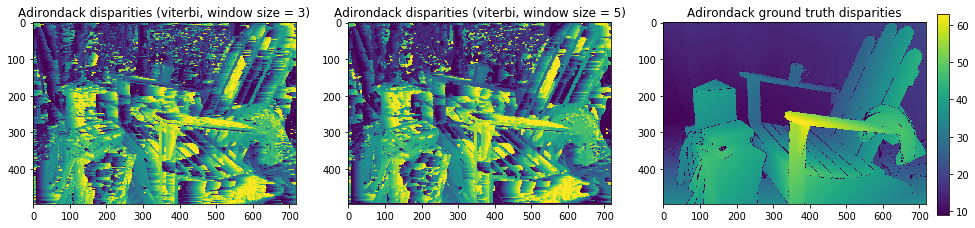

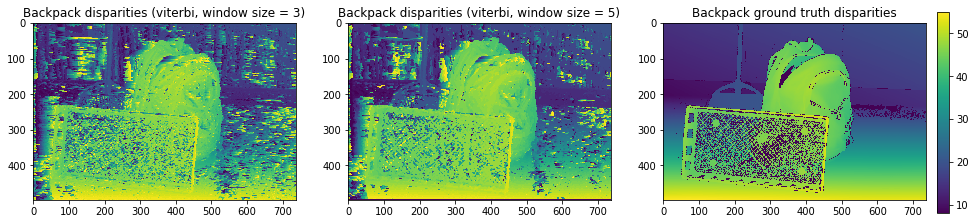

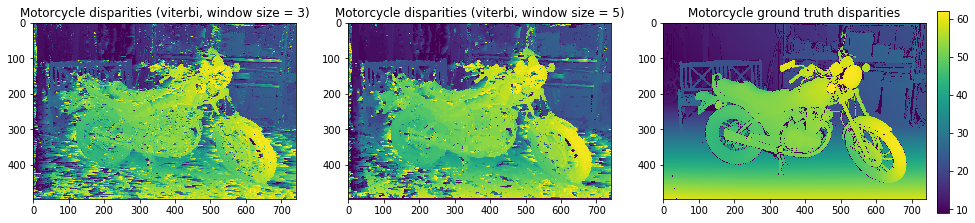

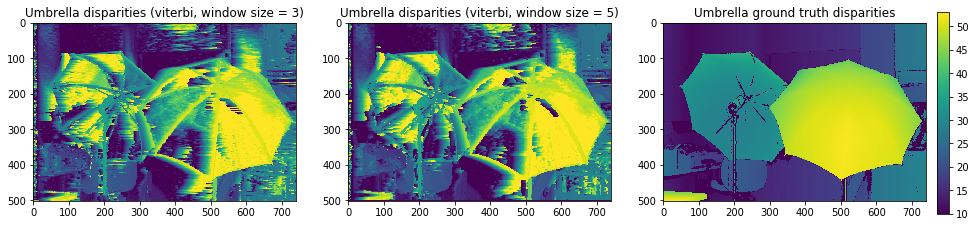

In [6]:
def window_viterbi_dispmap(im_left, im_right, d_min, d_max, w, window_size):
    SD = SD_array(im_left, im_right, d_min, d_max)
    SD_windows = np.array([windSum(s, window_size) for s in SD])
    SD_windows[SD_windows == INFTY] = 0
    disps = np.array(range(d_min, d_max + 1))
    # matrix of regularization weights for disparities:
    disp_curr = np.transpose(np.tile(disps, (len(disps), 1)))
    disp_prev = np.tile(disps, (len(disps), 1))
    reg_weight = w * np.absolute(disp_curr - disp_prev)
    
    return dispMapViterbi(im_right, disps, SD_windows, reg_weight)

for name, info in images.items():
    images[name]['viterbi_small'] = window_viterbi_dispmap(info['left'], info['right'], info['d_min'], info['d_max'], 15, 3)
    images[name]['viterbi_large'] = window_viterbi_dispmap(info['left'], info['right'], info['d_min'], info['d_max'], 15, 5)
    plots = [images[name]['viterbi_small'], images[name]['viterbi_large'], info['gt']]
    titles = [name + " disparities (viterbi, window size = 3)", name + " disparities (viterbi, window size = 5)", name + " ground truth disparities"]
    display_image_plots(plots, titles, vmin = info['d_min'], vmax = info['d_max'], colorbar_info = [0.91, 0.3, 0.01, 0.4])

## Full Grid Stereo

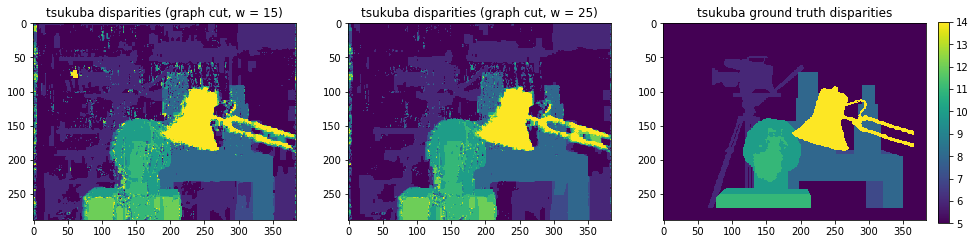

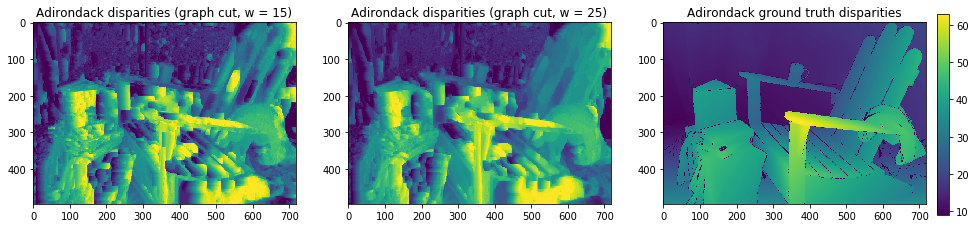

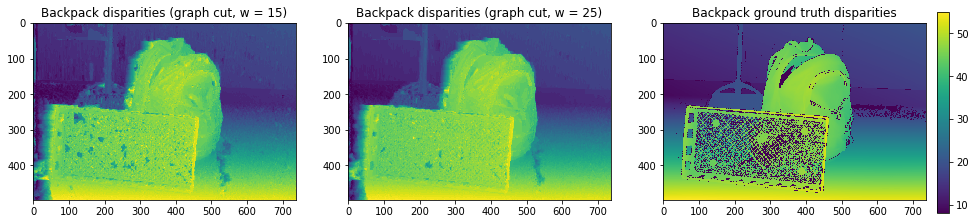

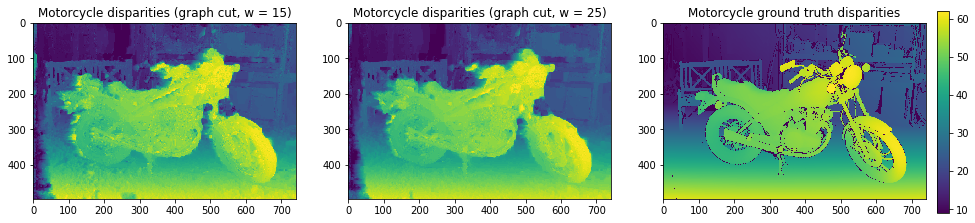

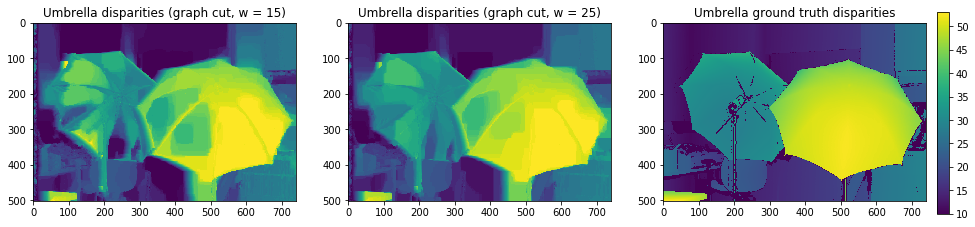

In [7]:
import maxflow

# size is a tuple (length, width), which gives the size of the grid for each layer
# z_weights is an array of size (depth, length, width) (z measures depth)
# x_weights is an array of size (length, width)
# y_weights is an array of size (length, width)
# note depth must be >= 2

# to add edges of "infinite" cost in the opposite direction, we
# use the max cost amongst the weights in z_weights, x_weights, y_weights, 
# multiplied by the number of neighbours (there are 6, but we'll do *10)

def graph_cut_3d(size, z_weights, x_weights, y_weights):
    g = maxflow.GraphInt()
    
    # will use these throughout
    depth, length, width = z_weights.shape
    zeros = np.zeros((length, width))
    inf_cost = 100 * np.amax([np.amax(z_weights), np.amax(x_weights), np.amax(y_weights)])
    
    x_neighbours = [[[0, 0, 0],
                     [0, 0, 0],
                     [0, 0, 0]],
                    [[0, 0, 0],
                     [0, 0, 1],
                     [0, 0, 0]],
                    [[0, 0, 0],
                     [0, 0, 0],
                     [0, 0, 0]]]
    y_neighbours = [[[0, 0, 0],
                     [0, 0, 0],
                     [0, 0, 0]],
                    [[0, 0, 0],
                     [0, 0, 0],
                     [0, 1, 0]],
                    [[0, 0, 0],
                     [0, 0, 0],
                     [0, 0, 0]]]
    z_neighbours_d = [[[0, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]],
                      [[0, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]],
                      [[0, 0, 0],
                       [0, 1, 0],
                       [0, 0, 0]]]
    z_neighbours_u = [[[0, 0, 0], 
                       [0, 1, 0],
                       [0, 0, 0]],
                      [[0, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]],
                      [[0, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]]] # for inf costs 
    nodes = g.add_grid_nodes((depth-1, length, width))
    
    g.add_grid_edges(nodes, x_weights, structure = x_neighbours, symmetric = True)
    g.add_grid_edges(nodes, y_weights, structure = y_neighbours, symmetric = True)
    if depth > 2:
        g.add_grid_edges(nodes, z_weights[1:], structure = z_neighbours_d, symmetric = False)
        g.add_grid_edges(nodes, np.full((depth - 1, length, width), inf_cost), structure = z_neighbours_u, symmetric = False)
    first_layer = nodes[0]
    last_layer = nodes[-1]
    g.add_grid_tedges(first_layer, z_weights[0], zeros)
    g.add_grid_tedges(last_layer, zeros, z_weights[-1])
    
    energy = g.maxflow()
    return 1*g.get_grid_segments(nodes)

def graph_cut_dispmap(im_left, im_right, d_min, d_max, w):
    SD = SD_array(im_left, im_right, d_min, d_max) # z weights
    size = (len(SD) - 1, im_left.shape[0], im_left.shape[1])
    xy_weights = np.full(size, w)
    segmentation = graph_cut_3d(size, SD, xy_weights, xy_weights)
    dispmap = d_min + np.argmax(segmentation, axis = 0)
    dispmap[segmentation[-1] == 0] = d_max
    return dispmap

for name, info in images.items():
    images[name]['gc_low_w'] = graph_cut_dispmap(info['left'], info['right'], info['d_min'], info['d_max'], 15)
    images[name]['gc_high_w'] = graph_cut_dispmap(info['left'], info['right'], info['d_min'], info['d_max'], 25)
    plots = [images[name]['gc_low_w'], images[name]['gc_high_w'], info['gt']]
    titles = [name + " disparities (graph cut, w = 15)", name + " disparities (graph cut, w = 25)", name + " ground truth disparities"]
    display_image_plots(plots, titles, vmin = info['d_min'], vmax = info['d_max'], colorbar_info = [0.91, 0.3, 0.01, 0.4])

In [9]:
def ssd(disp, gt):
    return np.sum(np.square(disp - gt))

for name, info in images.items():
    images[name]['window_small_ssd'] = ssd(info['window_small'], info['gt'])
    images[name]['window_large_ssd'] = ssd(info['window_large'], info['gt'])
    
    images[name]['viterbi_low_w_ssd'] = ssd(info['viterbi_low_w'], info['gt'])
    images[name]['viterbi_high_w_ssd'] = ssd(info['viterbi_high_w'], info['gt'])
    
    images[name]['viterbi_small_ssd'] = ssd(info['viterbi_small'], info['gt'])
    images[name]['viterbi_large_ssd'] = ssd(info['viterbi_large'], info['gt'])
    
    images[name]['gc_low_w_ssd'] = ssd(info['gc_low_w'], info['gt'])
    images[name]['gc_high_w_ssd'] = ssd(info['gc_high_w'], info['gt'])
    
    # print ssd for now
    print(f'{name}')
    print(images[name]['window_small_ssd'])
    print(images[name]['window_large_ssd'])
    print(images[name]['viterbi_low_w_ssd'])
    print(images[name]['viterbi_high_w_ssd'])
    print(images[name]['viterbi_small_ssd'])
    print(images[name]['viterbi_large_ssd'])
    print(images[name]['gc_low_w_ssd'])
    print(images[name]['gc_high_w_ssd'])
    print()

tsukuba
1411134.0
785818.0
1750947.0
1441688.0
1460647.0
1336776.0
1266414.0
1187363.0

Adirondack
110810977.2250254
89411784.5166819
114884164.31720565
100124440.0863707
104662468.67540954
101916906.0140078
74631920.48231336
62347635.09810661

Backpack
103414031.27114102
98676163.18338008
89000198.93688962
75919240.19121738
91153125.26043698
89223111.77513501
69673114.22826764
70301827.76577374

Motorcycle
83996566.67687388
80037100.94277546
71564648.62910433
60627333.45627378
72195248.1165292
70513004.42603466
50350106.577134825
48674587.313567854

Umbrella
77769480.16493045
71701552.86813556
68045821.0370103
53409942.127660856
71970043.24451075
72930819.50612842
33934409.84852991
29479265.58847628



|Name | window_small_ssd | window_large_ssd | viterbi_low_w_ssd | viterbi_high_w_ssd | viterbi_small_ssd | viterbi_large_ssd | gc_low_w_ssd | gc_high_w_ssd |
|-----|------------------|------------------|-------------------|--------------------|-------------------|-------------------|-|-|
|tsukuba | 1,411,134 | 785,818 | 1,750,947 | 1,441,688 | 1,460,647 | 1,336,776 | 1,266,414 | 1,187,363 |
|Adirondack | 110,810,977 | 89,411,784 | 114,884,164 | 100,124,440 | 104,662,468 | 101,916,906 | 74,631,920 | 62,347,635 |
|Backpack | 103,414,031 | 98,676,163 | 89,000,198 | 75,919,240 | 91,153,125 | 89,223,111 | 69,673,114 | 70,301,827 |
|Motorcycle | 83,996,566 | 80,037,100 | 71,564,648 | 60,627,333 | 72,195,248 | 70,513,004 | 50,350,106 | 48,674,587 |
|Umbrella | 77,769,480 | 71,701,552 | 68,045,821 | 53,409,942 | 71,970,043 | 72,930,819 | 33,934,409 | 29,479,265 |

## Conclusion
two-three paragraphs summarizing the conclusions of your project